In [ ]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

--2022-05-22 11:26:00--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py [following]
--2022-05-22 11:26:00--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48687 (48K) [text/plain]
Saving to: ‘thinkdsp.py’

thinkdsp.py         100%[===================>]  47.55K  --.-KB/s    in 0.001s  

2022-05-22 11:26:00 (63.9 MB/s) - ‘thinkdsp.py’ saved [48687/48687]



# Упражнение 8.1

Была проверена работа примеров в блокноте chap08.ipynb

В блокноте для главы 8 присутствует интерактивный виджет, где можно экспериментировать с параметрами гауссова окна и изучить их влияние на частоту среза.


In [ ]:
import numpy as np
def zero_pad(array, n):
    res = np.zeros(n)
    res[:len(array)] = array
    return res

In [ ]:
from thinkdsp import SquareSignal, Wave, decorate
import scipy.signal
import matplotlib.pyplot as plt

def plot_filter(M=11, std=2):
    signal = SquareSignal(freq=440)
    wave = signal.make_wave(duration=1, framerate=44100)
    spectrum = wave.make_spectrum()

    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)

    ys = np.convolve(wave.ys, gaussian, mode='same')
    smooth = Wave(ys, framerate=wave.framerate)
    spectrum2 = smooth.make_spectrum()

    # plot the ratio of the original and smoothed spectrum
    amps = spectrum.amps
    amps2 = spectrum2.amps
    ratio = amps2 / amps    
    ratio[amps<560] = 0

    # plot the same ratio along with the FFT of the window
    padded = zero_pad(gaussian, len(wave))
    dft_gaussian = np.fft.rfft(padded)

    plt.plot(np.abs(dft_gaussian), color='gray', label='Gaussian filter')
    plt.plot(ratio, label='amplitude ratio')

    decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')
    plt.show()

In [ ]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=2, max=100, value=11)
slider2 = widgets.FloatSlider(min=0, max=20, value=2)
interact(plot_filter, M=slider, std=slider2);

interactive(children=(IntSlider(value=11, description='M', min=2), FloatSlider(value=2.0, description='std', m…

Если при увеличении ширины гауссова окна std не увеличивать число элементов в окне M, то усиливаются колебания называемые *боковыми лепестками*.

# Упражнение 8.2

В главе 8 утверждается, что преобразование Фурье гауссовой кривой — также гауссова кривая. Для дискретного преобразования
Фурье это сотношение приблизительно верно.


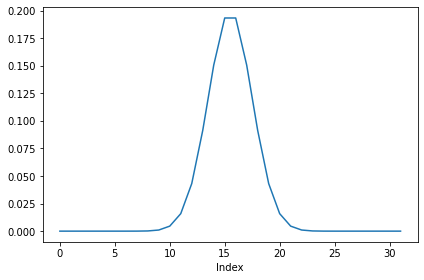

In [ ]:
gaussian = scipy.signal.gaussian(M=32, std=2)
gaussian /= sum(gaussian)
plt.plot(gaussian)
decorate(xlabel='Index')

Было выполнено быстрое преобразование Фурье для гауссовой кривой:

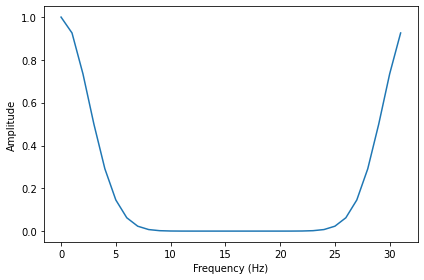

In [ ]:
fft_gaussian = np.fft.fft(gaussian)
plt.plot(abs(fft_gaussian))
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

После была произведена свертка отрицательных частот влево.

Результат приблизительно похож на гауссову кривую:

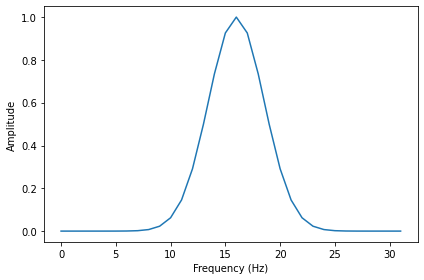

In [ ]:
N = len(gaussian)
fft_rolled = np.roll(fft_gaussian, N//2)
plt.plot(abs(fft_rolled))
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

Функция plot_gaussian печатает рядом графики Гауссова фильтра и БПФ.

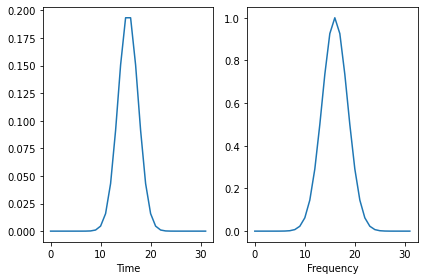

In [ ]:
def plot_gaussian(std):
    M = 32
    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)
    
    plt.subplot(1, 2, 1)
    plt.plot(gaussian)
    decorate(xlabel='Time')

    fft_gaussian = np.fft.fft(gaussian)
    fft_rolled = np.roll(fft_gaussian, M//2)
    
    plt.subplot(1, 2, 2)
    plt.plot(np.abs(fft_rolled))
    decorate(xlabel='Frequency')
    plt.show()

plot_gaussian(2)

In [ ]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.FloatSlider(min=0.1, max=10, value=2)
interact(plot_gaussian, std=slider);

interactive(children=(FloatSlider(value=2.0, description='std', max=10.0, min=0.1), Output()), _dom_classes=('…

По мере увеличения std кривая Гаусса становится шире, а БПФ - более узким.

# Упражнение 8.3

Существует много других окон помимо Гауссова, использованного в этой главе, например, окно Хэмминга.

Необходимо исследовать какое окно больше подходит для фильтра НЧ.

In [ ]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(freq=440)
wave = signal.make_wave(duration=1.0, framerate=44100)

Были создан 5 видов окон.

In [ ]:
M = 15
std = 2.5

gaussian = scipy.signal.gaussian(M=M, std=std)   
bartlett = np.bartlett(M)
blackman = np.blackman(M)
hamming = np.hamming(M)
hanning = np.hanning(M)

windows = [blackman, bartlett, gaussian, hanning, hamming]
names = ['blackman', 'bartlett', 'gaussian', 'hanning', 'hamming']

for window in windows:
    window /= sum(window)

Для наглядности были постороены графики.

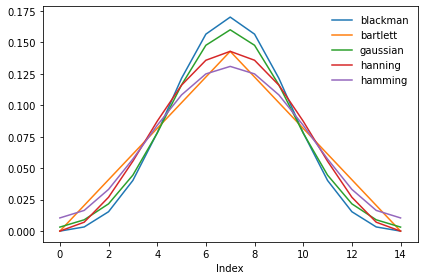

In [ ]:
for window, name in zip(windows, names):
    plt.plot(window, label=name)

decorate(xlabel='Index')

Следом для окон было выполнено ДПФ.

In [ ]:
def plot_window_dfts(windows, names):
    for window, name in zip(windows, names):
        padded =  zero_pad(window, len(wave))
        dft_window = np.fft.rfft(padded)
        plt.plot(abs(dft_window), label=name)

Для полученных результатов были построены графики.

Быстрее всего падает кривая Хэмминга, медленнее всего - кривая Блэкмана.

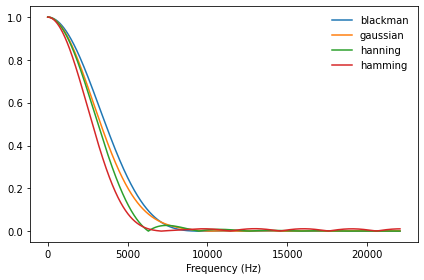

In [ ]:
plot_window_dfts(windows, names)
decorate(xlabel='Frequency (Hz)')

Этот же график, напечатанный с логарифмическим масштабом по $y$.

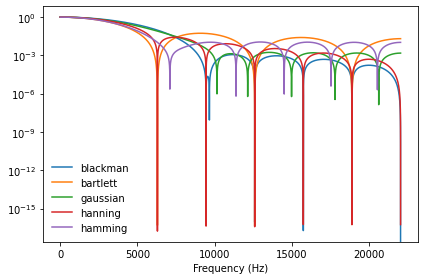

In [ ]:
plot_window_dfts(windows, names)
decorate(xlabel='Frequency (Hz)', yscale='log')

Логарифимическйи масштаб позволяет отметить, что кривая графика Хэннинга имеет наиболее заметные *боковые лепестки*.